# Examples of configuring and running NSGA-II

This notebook includes examples where the NSGA-II algorithm is used to solve continuous and binary multi-objective problems. 

There are two basic ways of using NSGA-II with MetaJul. The first one is using the `EvolutionaryAlgorithm` struct, which must be populated with specific components characterizing NSGA-II, and the second one is based on the `NSGAII` struct, which constitutes a simpler way to obtain a standard NSGA-II but it does not offer the wide range of alternatives for setting up NSGA-II variants as the first option. We include examples of both schemes in the notebook.

In [33]:
using MetaJul
using Dates

## Configure NSGA-II to solve a continuous problem (Kursawe) using default settings.

The first step is to instantiate the problem to be solve. In this case, we choose the classical Kursawe continuous problem.

In [47]:
problem = kursawe() ;

The default settings of NSGA-II, used in many studies, are the following:


In [35]:
solver::NSGAII = NSGAII()
solver.problem = problem
solver.populationSize = 100

100

In [36]:
solver.termination = TerminationByEvaluations(25000)
solver.mutation = PolynomialMutation(1.0/numberOfVariables(problem),20.0, problem.bounds)
solver.crossover = SBXCrossover(1.0, 20.0, problem.bounds)

SBXCrossover(1.0, 20.0, Bounds[Bounds{Float64}(-5.0, 5.0), Bounds{Float64}(-5.0, 5.0), Bounds{Float64}(-5.0, 5.0)])

### Run the algorithm

In [37]:
startingTime = Dates.now()
optimize(solver)
endTime = Dates.now()

println("Computing time: ", (endTime - startingTime))

Computing time: 1584 milliseconds


### Print the results

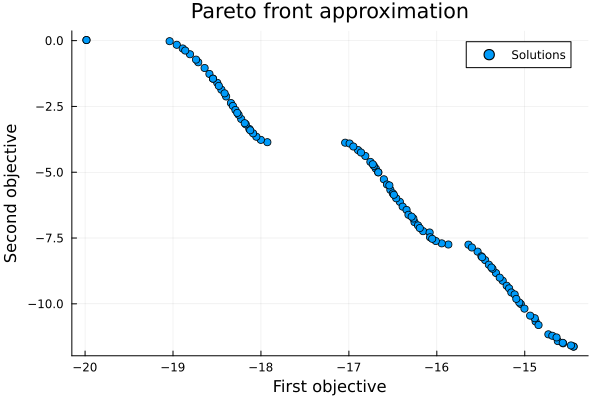

In [38]:
using Plots
 
#data to plot
x = [solution.objectives[1] for solution in solver.foundSolutions];
y = [solution.objectives[2] for solution in solver.foundSolutions];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")

## Configure the algorithm to solve a binary problem (OneZeroMax)

In [40]:
# The oneZeroMax function consists of miximizing the number of zeros and the number of ones in a binary string
problem = oneZeroMax(512)

BinaryProblem(512, Function[MetaJul.var"#201#204"(), MetaJul.var"#202#205"()], Function[], "OneZeroMax")

In [41]:
solver::NSGAII = NSGAII()
solver.problem = problem
solver.populationSize = 100

100

In [42]:
solver.termination = TerminationByComputingTime(Dates.Second(2))
solver.mutation = BitFlipMutation(1.0/numberOfVariables(problem))
solver.crossover = SinglePointCrossover(1.0)

SinglePointCrossover(1.0)

In [43]:
startingTime = Dates.now()
optimize(solver)
endTime = Dates.now()

println("Computing time: ", (endTime - startingTime))

Computing time: 2004 milliseconds


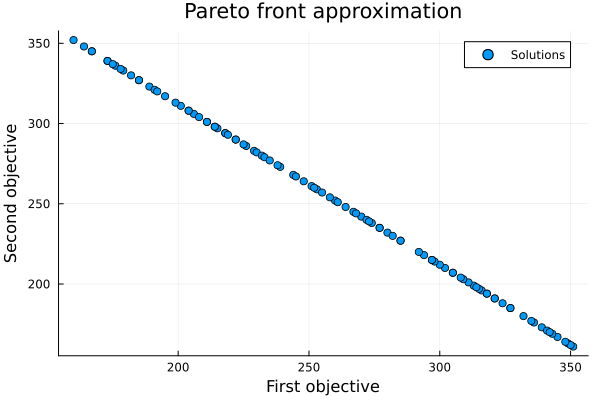

In [44]:
# data to plot
x = [solution.objectives[1] for solution in solver.foundSolutions];
y = [solution.objectives[2] for solution in solver.foundSolutions];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")